In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import glob
from myFunctions import lcl
from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import atmos
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker

def f_calc_tot_cloud_fraction(matrix):
    '''
    function to calculate the total cloud fraction of a matrix (time, height)
    

    Parameters
    ----------
    matrix : ndarray (time, height)
        DESCRIPTION. reflectivity values

    Returns
    -------
    cloud fraction ndarray(time)

    '''
    #defining ndarray to contain cloud fraction
    cloud_fraction = []
    N_tot = matrix.shape[0]
    for ind_height in range(matrix.shape[1]):
        cloud_fraction.append(np.sum(~np.isnan(matrix[:,ind_height]))/N_tot)


    return(np.asarray(cloud_fraction))


In [2]:
# reading data containing flags to filter out rainy columns
flag_file_list = np.sort(glob.glob('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/*_flags_cloud_properties.nc'))
flag_file_list = flag_file_list[13:15]
cp_data = xr.open_mfdataset(flag_file_list)

# reading radar file list
file_list = np.sort(glob.glob("/Volumes/Extreme SSD/ship_motion_correction_merian/corrected_data/wband_daily_with_DOI/latest/with_DOI/daily_intake/*.nc"))
file_list = file_list[14:16]
radar_data = xr.open_mfdataset(file_list)
time = radar_data.time.values


# reading tsg file ( data with 1 min resolution)
tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords         = {"time":sliced_tsg_ds.TIME.values}
SST              = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# interpolating SST data on radar time res
SST_interp = SST_DS.interp(time=time)

# merging SST and radar data
data_merged = xr.merge([radar_data, SST_interp, cp_data])

# setting LWP values below 5 gm-2 to np.nan
ind_nan = np.where(data_merged.liquid_water_path.values < 5.)[0]
LWP_new = data_merged.liquid_water_path.values
LWP_new[ind_nan] = np.nan

LWP_data = xr.DataArray(dims=dim_sst, coords={'time':data_merged.time.values}, data=LWP_new,
                 attrs={'long_name':'liquid water path',
                        'units':'ms$^{-1}$'})
data_merged['liquid_water_path'] = LWP_data



In [3]:
data_merged

<xarray.Dataset>
Dimensions:                      (height: 550, time: 53433)
Coordinates:
  * time                         (time) datetime64[ns] 2020-02-02T00:00:01 .....
  * height                       (height) float32 104.3517 111.8054 ... 9982.643
    lat                          (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    lon                          (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
Data variables:
    rain_rate                    (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    relative_humidity            (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    air_temperature              (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    air_pressure                 (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    wind_speed                   (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    wind_direction               (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    liquid_water_path            (time) float32 nan nan nan nan ... nan nan nan
    brightness_temperature       (time) float32 dask.array<chunksize=(26713,), meta=np.ndarray>
    mean_doppler_velocity        (time, height) float32 dask.array<chunksize=(26713, 550), meta=np.ndarray>
    radar_reflectivity           (time, height) float32 dask.array<chunksize=(26713, 550), meta=np.ndarray>
    spectral_width               (time, height) float32 dask.array<chunksize=(26713, 550), meta=np.ndarray>
    skewness                     (time, height) float32 dask.array<chunksize=(26713, 550), meta=np.ndarray>
    instrument                   (time) <U15 'msm_wband_radar' ... 'msm_wband...
    SST                          (time) float64 nan nan nan ... 26.98 26.98 nan
    flag_cloud_base              (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    flag_cloud_base_source       (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    flag_rain                    (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    flag_rain_ground             (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    cloud_top_height             (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    cloud_geometrical_thickness  (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>
    cloud_base                   (time) float64 dask.array<chunksize=(26713,), meta=np.ndarray>

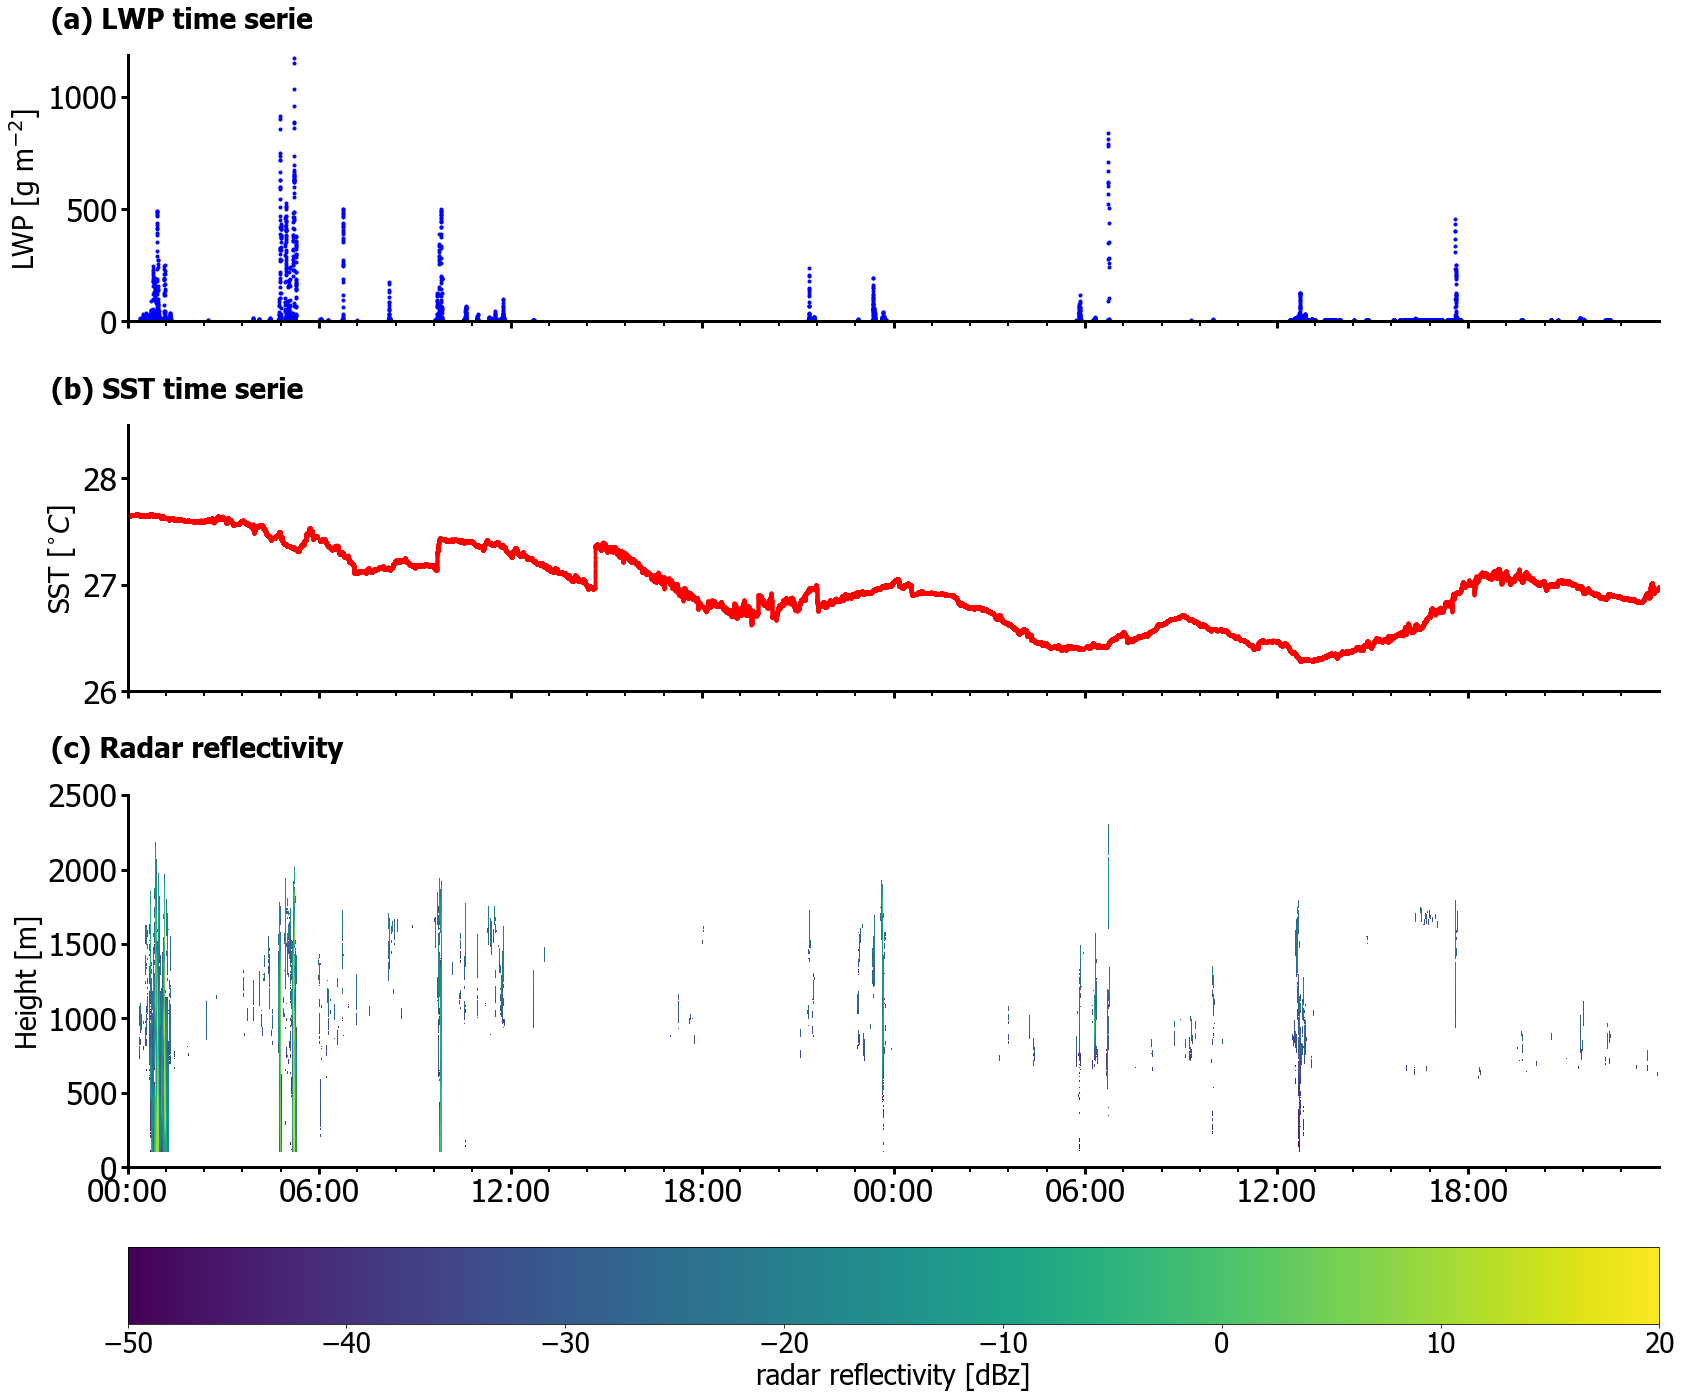

In [4]:
# time series of all LWP and reflectiviy variables
time = data_merged.time.values
height = data_merged.height.values
dict_plot_settings = {
    'labelsizeaxes':14,
    'fontSizeTitle':16,
    'fontSizeX'    :28,
    'fontSizeY'    :28,
    'cbarAspect'   :10,
    'fontSizeCbar' :28,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :28, 
    'grid'         :True}


# composite figure variables binned in sst 
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']
fig, axes = plt.subplots( figsize=(24,20), nrows=3, sharex=True, gridspec_kw={'height_ratios': [1,1,2]} )
axes[0].plot(time, data_merged.liquid_water_path, linestyle='None', marker='o', markersize=3., mec='b', mfc='b')
axes[0].set_ylabel('LWP [g m$^{-2}$]')
axes[0].set_ylim(-1., np.nanmax(data_merged.liquid_water_path)+10.)  # limets of the x-axes)  # limets of the x-axes
#axes[0].grid(True, which="both")

mesh = axes[2].pcolormesh(time, height, data_merged.radar_reflectivity.values.T, cmap='viridis', vmin=-50., vmax=20.)
cbar = fig.colorbar(mesh, ax=axes[2], orientation='horizontal')
cbar.set_label(label='radar reflectivity [dBz]',  size=fontSizeX)
axes[2].set_ylim(0., 2500.)
axes[2].set_ylabel('Height [m]')
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

axes[1].plot(time, data_merged.SST, linestyle='None', marker='o', markersize=3., mec='r', mfc='r')
axes[1].set_ylabel('SST [$^{\circ}C$]')
axes[1].set_ylim(-1., np.nanmax(data_merged.liquid_water_path)+10.)  # limets of the x-axes)  # limets of the x-axes
#axes[0].grid(True, which="both")
axes[1].set_ylim(26., 28.5)

for ax, l in zip(axes[:].flatten(), ['(a) LWP time serie',  '(b) SST time serie', '(c) Radar reflectivity']):
    ax.text(-0.05, 1.1, l,  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_linewidth(3)
    ax.spines["left"].set_linewidth(3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(which='minor', length=5, width=2)
    ax.tick_params(which='major', length=7, width=3)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    ax.tick_params(axis='both', labelsize=32)
fig.tight_layout()

In [5]:
# filtering rainy columns and non rainy ones in different datasets

# selecting slices of datasets columns with SST values in the selected bin
time = data_merged.time.values
rain_index = np.where(data_merged.flag_rain_ground.values == 1)[0]
no_rain_index = np.where(data_merged.flag_rain_ground.values == 0)[0]

Data_rain = data_merged.sel(time=time[rain_index], drop=True)
Data_no_rain = data_merged.sel(time=time[no_rain_index], drop=True)




In [13]:
# building binned array of sst
sst_tsg = SST_interp.SST.values
bin_size = 0.25
SST_binned_arr = np.round(np.arange(np.nanmin(sst_tsg),np.nanmax(sst_tsg), bin_size),1)


#defining color palette for subsequent plots
colors_binned_sst = plt.cm.seismic(np.linspace(0, 1, len(SST_binned_arr)))
SST_binned_arr

array([26.3, 26.5, 26.8, 27. , 27.3, 27.5])

In [7]:
def f_binning_dataset_vs_SST(data_merged, SST_binned_arr):

    # calculating mean Ze profiles for each SST bin
    dataset_mean = []
    data_sliced_all = []
    # selecting all columns in the bin interval
    for ind_bin in range(len(SST_binned_arr)-1):

        # selecting slices of datasets columns with SST values in the selected bin
        DS_sliced = data_merged.where((data_merged.SST > SST_binned_arr[ind_bin]) & (data_merged.SST < SST_binned_arr[ind_bin+1]), drop=True)

        # calculating cloud fraction for the sliced dataset
        Ze_matrix = DS_sliced.radar_reflectivity.values        
        cloud_fraction = f_calc_tot_cloud_fraction(Ze_matrix)
        print(np.shape(cloud_fraction), np.shape(DS_sliced.height.values))
        
        #adding cloud fraction as a variable in the binned dataset
        dim_sst        = ['height']
        coords         = {'height':DS_sliced.height.values}
        cf_data        = xr.DataArray(dims=dim_sst, coords=coords, data=cloud_fraction,
                 attrs={'long_name':'hydrometeor fraction',
                        'units':''})
        # add variable of the number of elements of the slice
        n_el = len(DS_sliced.SST.values)
        DS_sliced['n_elements'] = n_el
        DS_sliced['hyd_fraction'] = cf_data
        
        # calculate mean profile averaging all selected time stamps together
        dataset_mean.append(DS_sliced.mean(dim='time', skipna=True))
        data_sliced_all.append(DS_sliced)

    # concatenating datasets corresponding to SST bins on a new bin dimension
    dataset_concat = xr.concat([dataset_mean[i] for i in np.arange(len(dataset_mean))], dim='SST_binned')
    dataset_all_data_concat = xr.concat([data_sliced_all[i] for i in np.arange(len(data_sliced_all))], dim='SST_binned')

    return(dataset_concat, dataset_all_data_concat)


# binning with respect to SST both datasets
no_rain_binned, all_no_rain_binned = f_binning_dataset_vs_SST(Data_no_rain, SST_binned_arr)
rain_binned, all_rain_binned = f_binning_dataset_vs_SST(Data_rain, SST_binned_arr)

(550,) (550,)
(550,) (550,)
(550,) (550,)
(550,) (550,)
(550,) (550,)


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


(550,) (550,)
(550,) (550,)
(550,) (550,)
(550,) (550,)
(550,) (550,)


/Users/claudia/opt/anaconda3/lib/python3.8/site-packages/xarray/core/alignment.py:307: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  index = joiner(matching_indexes)


In [8]:
all_no_rain_binned

<xarray.Dataset>
Dimensions:                      (SST_binned: 5, height: 550, time: 46908)
Coordinates:
  * time                         (time) datetime64[ns] 2020-02-02T03:56:48 .....
  * height                       (height) float32 104.3517 111.8054 ... 9982.643
    lat                          (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    lon                          (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
Dimensions without coordinates: SST_binned
Data variables:
    rain_rate                    (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    relative_humidity            (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    air_temperature              (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    air_pressure                 (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    wind_speed                   (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    wind_direction               (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    liquid_water_path            (SST_binned, time) float32 nan nan ... nan nan
    brightness_temperature       (SST_binned, time) float32 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    mean_doppler_velocity        (SST_binned, time, height) float32 dask.array<chunksize=(1, 21097, 550), meta=np.ndarray>
    radar_reflectivity           (SST_binned, time, height) float32 dask.array<chunksize=(1, 21097, 550), meta=np.ndarray>
    spectral_width               (SST_binned, time, height) float32 dask.array<chunksize=(1, 21097, 550), meta=np.ndarray>
    skewness                     (SST_binned, time, height) float32 dask.array<chunksize=(1, 21097, 550), meta=np.ndarray>
    instrument                   (SST_binned, time) object nan nan ... nan nan
    SST                          (SST_binned, time) float64 nan nan ... nan nan
    flag_cloud_base              (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    flag_cloud_base_source       (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    flag_rain                    (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    flag_rain_ground             (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    cloud_top_height             (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    cloud_geometrical_thickness  (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    cloud_base                   (SST_binned, time) float64 dask.array<chunksize=(1, 21097), meta=np.ndarray>
    n_elements                   (SST_binned) int64 7797 9989 12001 11636 5485
    hyd_fraction                 (SST_binned, height) float64 0.0 0.0 ... 0.0

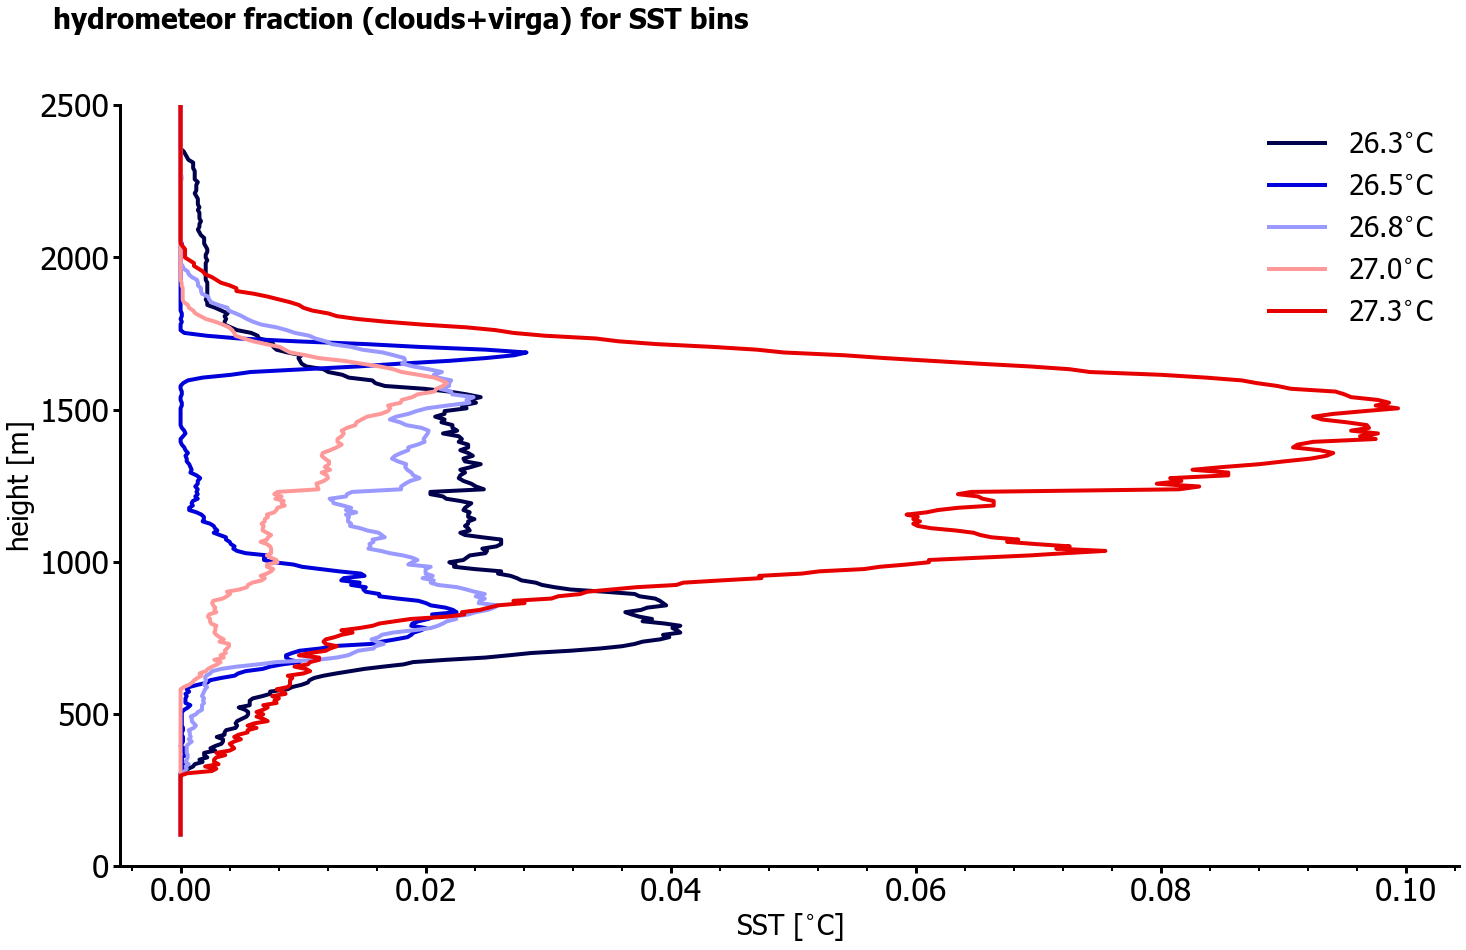

In [9]:
fig, ax = plt.subplots(figsize=(24,14))
ax.text(-0.05, 1.1, 'hydrometeor fraction (clouds+virga) for SST bins',  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.tick_params(which='minor', length=5, width=2)
ax.tick_params(which='major', length=7, width=3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.tick_params(axis='both', labelsize=32)
# plot mean profiles
for ind in range(len(SST_binned_arr)-1):

    ax.plot(no_rain_binned.hyd_fraction.values[ind,:], \
            no_rain_binned.height.values,\
            color=colors_binned_sst[ind],\
            label=str(SST_binned_arr[ind])+'$^{\circ}$C',  linewidth=4, rasterized=True)
ax.set_ylim(0.,  2500.)
ax.set_ylabel('height [m]')
ax.set_xlabel('SST [$^{\circ}$C]')

ax.legend(frameon=False)   
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots/'

fig.savefig(path_out_plots+'figure_cloud_fraction_binned.png', format='png')

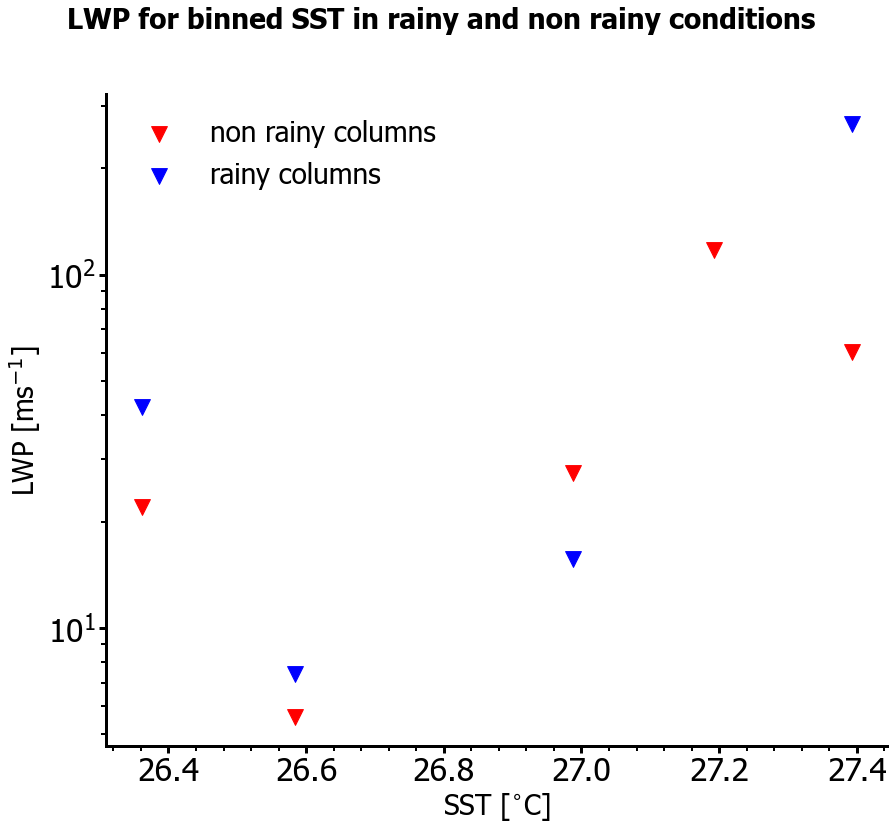

In [10]:
#plt.plot(rain_binned.SST.values,rain_binned.liquid_water_path, label='LWP')
fig, ax = plt.subplots(figsize=(14,12))
ax.text(-0.05, 1.1, 'LWP for binned SST in rainy and non rainy conditions',  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_linewidth(3)
ax.spines["left"].set_linewidth(3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.tick_params(which='minor', length=5, width=2)
ax.tick_params(which='major', length=7, width=3)
ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax.tick_params(axis='both', labelsize=32)
ax.scatter(rain_binned.SST.values,no_rain_binned.liquid_water_path, marker="v", s=250, color='r', label='non rainy columns')
ax.scatter(rain_binned.SST.values,rain_binned.liquid_water_path, marker="v", s=250,  color='b', label='rainy columns')
ax.legend(frameon=False)
ax.set_yscale('log')
ax.set_ylabel('LWP [ms$^{-1}$]')
ax.set_xlabel('SST [$^{\circ}$C]')
fig.savefig(path_out_plots+'figure_LWP.png', format='png')

In [12]:
print(rain_binned.SST.values)
print(SST_binned_arr)

[26.36103705 26.58443384 26.98759957 27.19235    27.39268079]
[26.3 26.5 26.8 27.  27.3 27.5]


In [12]:
ind_plot=0
xvar = all_no_rain_binned['radar_reflectivity'].values[ind_plot, :,:].flatten()

yvar = (np.ones((len(all_no_rain_binned.time.values),1))*np.array([all_no_rain_binned.height.values])).flatten()
np.shape(yvar)

(25799400,)

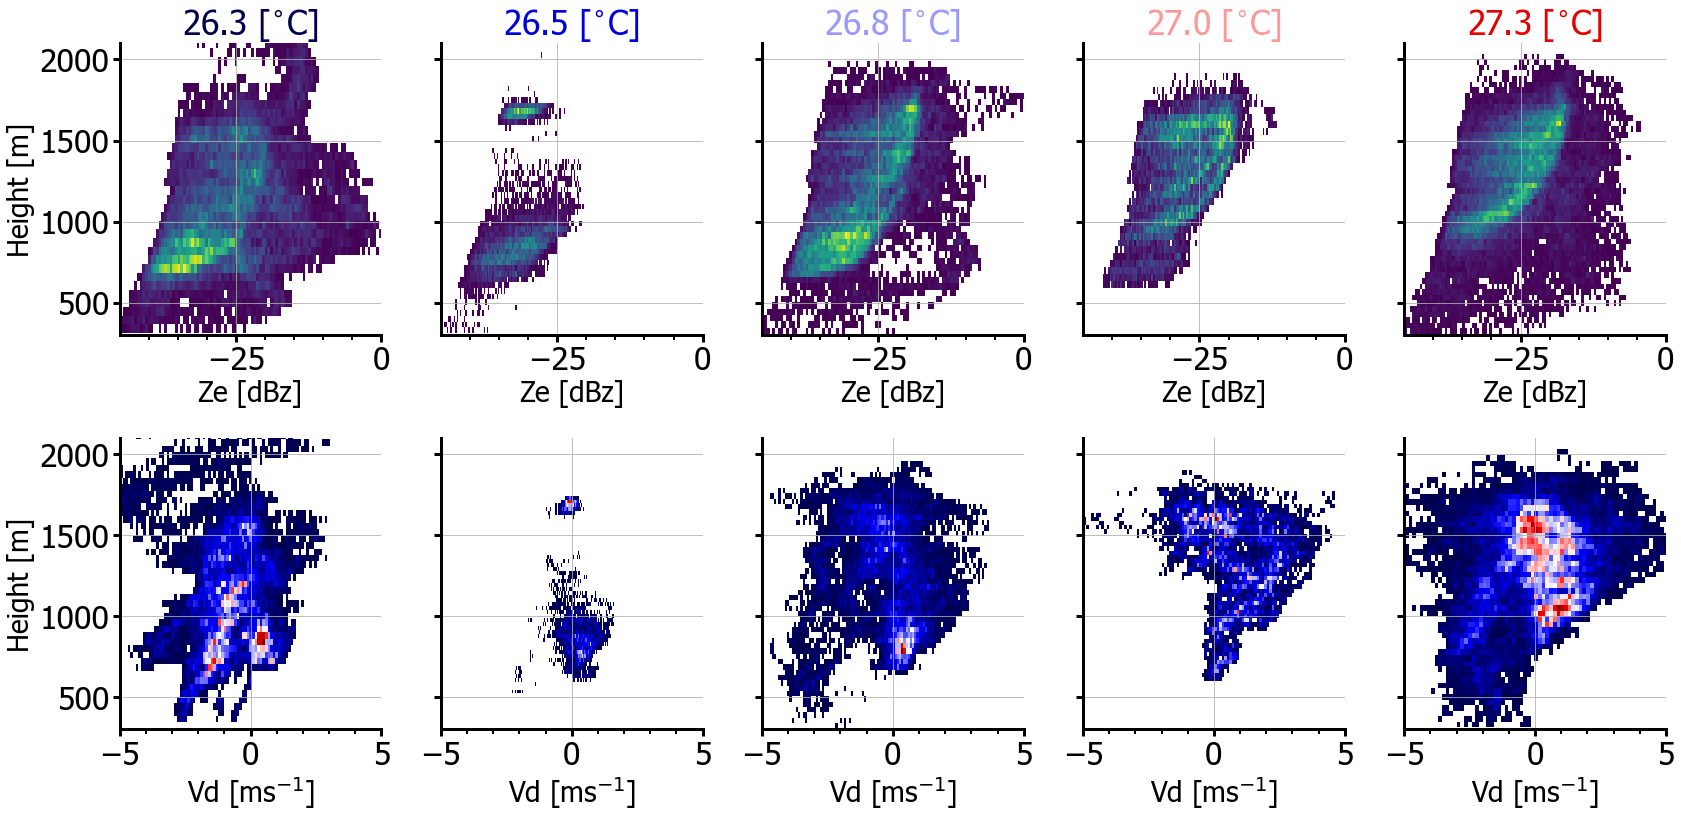

In [13]:
def calc_2d_hist(dataset, xvar):
    yvar = (np.ones((len(dataset.time.values),1))*np.array([dataset.height.values])).flatten()
    i_good = (~np.isnan(xvar) * ~np.isnan(yvar))
    hst, xedge, yedge = np.histogram2d(xvar[i_good], yvar[i_good], bins=[100,50])
    xcenter = (xedge[:-1] + xedge[1:])*0.5
    ycenter = (yedge[:-1] + yedge[1:])*0.5
    hst = hst.T
    hst[hst==0] = np.nan
    return(hst, xcenter, ycenter)


# plotting cfads for Ze of the binned datasets
fig, axs = plt.subplots(2,len(SST_binned_arr)-1,figsize=(24,12), sharey=True)

for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_no_rain_binned['radar_reflectivity'].values[ind_plot, :,:].flatten()
    hst, xcenter, ycenter = calc_2d_hist(all_no_rain_binned, xvar)
    cax = axs[0,ind_plot].pcolormesh(xcenter, ycenter, hst, cmap='viridis')
    axs[0,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[0,ind_plot].set_xlim(-45., 0.)
    axs[0,ind_plot].grid()
    axs[0,ind_plot].spines["top"].set_visible(False)
    axs[0,ind_plot].spines["right"].set_visible(False)
    axs[0,ind_plot].spines["bottom"].set_linewidth(3)
    axs[0,ind_plot].spines["left"].set_linewidth(3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[0,ind_plot].tick_params(which='major', length=7, width=3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(axis='both', labelsize=32)
    axs[0,ind_plot].set_xlabel('Ze [dBz]')
    axs[0,0].set_ylabel('Height [m]')
    axs[0,ind_plot].set_title(str(SST_binned_arr[ind_plot])+' [$^{\circ}$C]', color=colors_binned_sst[ind_plot])

for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_no_rain_binned['mean_doppler_velocity'].values[ind_plot, :,:].flatten()
    hst, xcenter, ycenter = calc_2d_hist(all_no_rain_binned, xvar)
    cax = axs[1,ind_plot].pcolormesh(xcenter, ycenter, hst, cmap='seismic')
    axs[1,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[1,ind_plot].set_xlim(-5., 5.)
    axs[1,ind_plot].grid()
    axs[1,ind_plot].spines["top"].set_visible(False)
    axs[1,ind_plot].spines["right"].set_visible(False)
    axs[1,ind_plot].spines["bottom"].set_linewidth(3)
    axs[1,ind_plot].spines["left"].set_linewidth(3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[1,ind_plot].tick_params(which='major', length=7, width=3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(axis='both', labelsize=32)    
    axs[1,ind_plot].set_xlabel('Vd [ms$^{-1}$]')
    axs[1,0].set_ylabel('Height [m]')

    
fig.tight_layout()
fig.savefig(path_out_plots+'figure_cfads_SST.png', format='png')
    

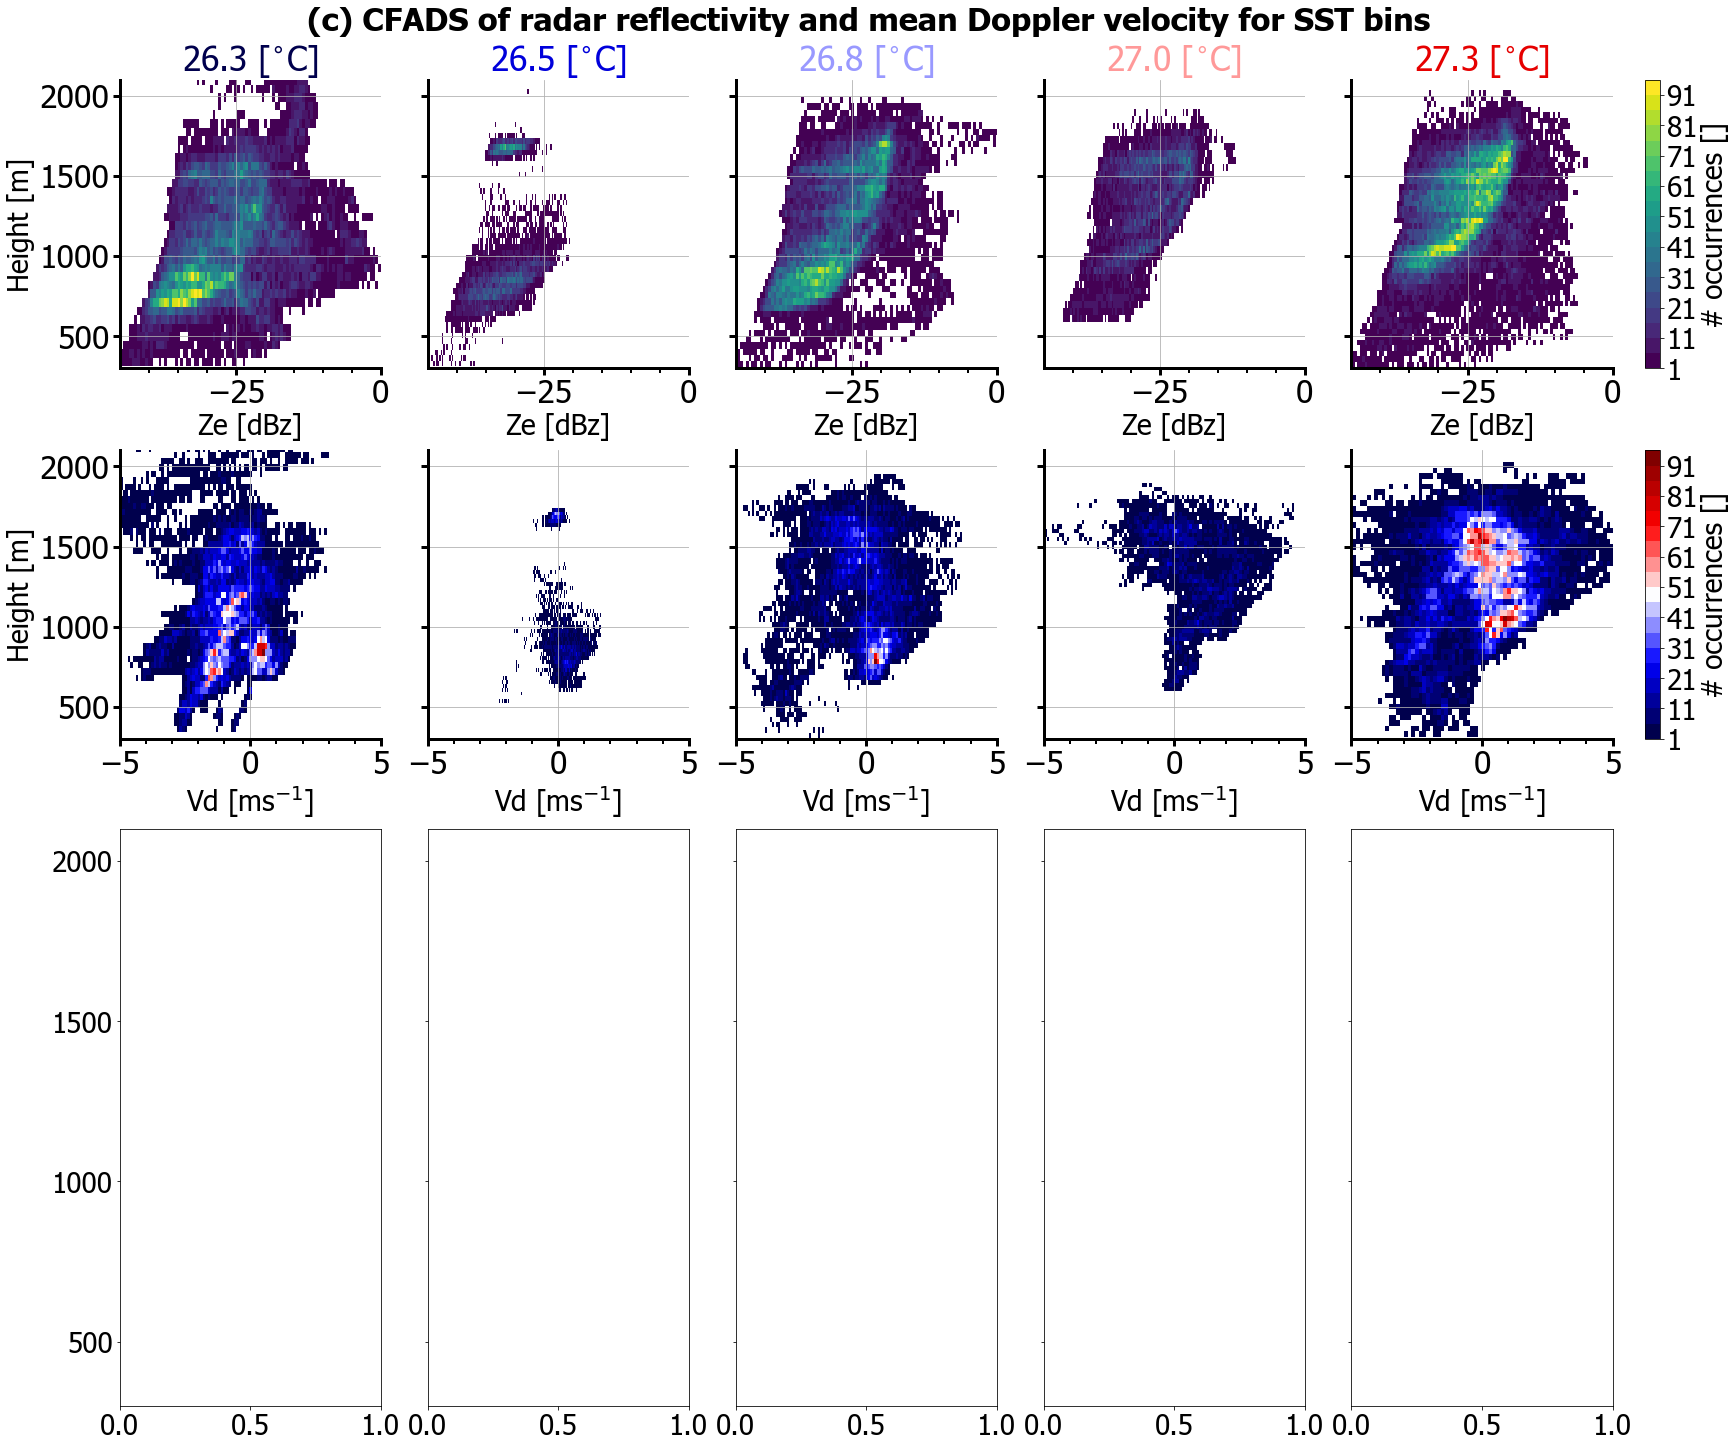

In [16]:
# creating a merged plot to be included in the paper
fig, axs = plt.subplots(3, len(SST_binned_arr)-1, figsize=(24,20), sharey=True, \
                        constrained_layout=True, gridspec_kw={'height_ratios': [1,1,2]})

fig.suptitle('(c) CFADS of radar reflectivity and mean Doppler velocity for SST bins', fontsize=32, fontweight='black')
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
#fig.subplots_adjust(top=0.78) 


# extract all colors from the .jet map
import matplotlib as mpl



for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_no_rain_binned['radar_reflectivity'].values[ind_plot, :,:].flatten()
    hst_ze, xcenter, ycenter = calc_2d_hist(all_no_rain_binned, xvar)
    cmap_ze = plt.cm.viridis  # define the colormap
    # define the bins and normalize
    bounds_ze = np.arange(1, 100, 5)
    norm_ze = mpl.colors.BoundaryNorm(bounds_ze, cmap_ze.N)
    cax = axs[0,ind_plot].pcolormesh(xcenter, ycenter, hst_ze, \
                                     cmap=cmap_ze, \
                                     norm = mpl.colors.BoundaryNorm(bounds_ze, ncolors=cmap_ze.N, clip=False))
    if (ind_plot == len(SST_binned_arr)-2):
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_ze, cmap=cmap_ze), ax=axs[0,ind_plot])
        cbar.set_label(label='# occurrences []',  size=fontSizeX)
    axs[0,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[0,ind_plot].set_xlim(-45., 0.)
    axs[0,ind_plot].grid()
    axs[0,ind_plot].spines["top"].set_visible(False)
    axs[0,ind_plot].spines["right"].set_visible(False)
    axs[0,ind_plot].spines["bottom"].set_linewidth(3)
    axs[0,ind_plot].spines["left"].set_linewidth(3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[0,ind_plot].tick_params(which='major', length=7, width=3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(axis='both', labelsize=32)
    axs[0,ind_plot].set_xlabel('Ze [dBz]')
    axs[0,0].set_ylabel('Height [m]')
    axs[0,ind_plot].set_title(str(SST_binned_arr[ind_plot])+' [$^{\circ}$C]', color=colors_binned_sst[ind_plot])

for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_no_rain_binned['mean_doppler_velocity'].values[ind_plot, :,:].flatten()
    hst, xcenter, ycenter = calc_2d_hist(all_no_rain_binned, xvar)
    cmap_vd = plt.cm.seismic  # define the colormap
    # define the bins and normalize
    bounds_vd = np.arange(1, 100, 5)
    norm_vd = mpl.colors.BoundaryNorm(bounds_vd, cmap_vd.N)
    cax = axs[1,ind_plot].pcolormesh(xcenter, ycenter, hst, \
                                     cmap=cmap_vd, \
                                     norm = mpl.colors.BoundaryNorm(bounds_vd, ncolors=cmap_vd.N, clip=False))
    if (ind_plot == len(SST_binned_arr)-2):
        cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm_vd, cmap=cmap_vd), ax=axs[1,ind_plot])
        cbar.set_label(label='# occurrences []',  size=fontSizeX)
    axs[1,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[1,ind_plot].set_xlim(-5., 5.)
    axs[1,ind_plot].grid()
    axs[1,ind_plot].spines["top"].set_visible(False)
    axs[1,ind_plot].spines["right"].set_visible(False)
    axs[1,ind_plot].spines["bottom"].set_linewidth(3)
    axs[1,ind_plot].spines["left"].set_linewidth(3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[1,ind_plot].tick_params(which='major', length=7, width=3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(axis='both', labelsize=32)    
    axs[1,ind_plot].set_xlabel('Vd [ms$^{-1}$]')
    axs[1,0].set_ylabel('Height [m]')
    

fig.savefig(path_out_plots+'figure_clouds_above.png', format='png')

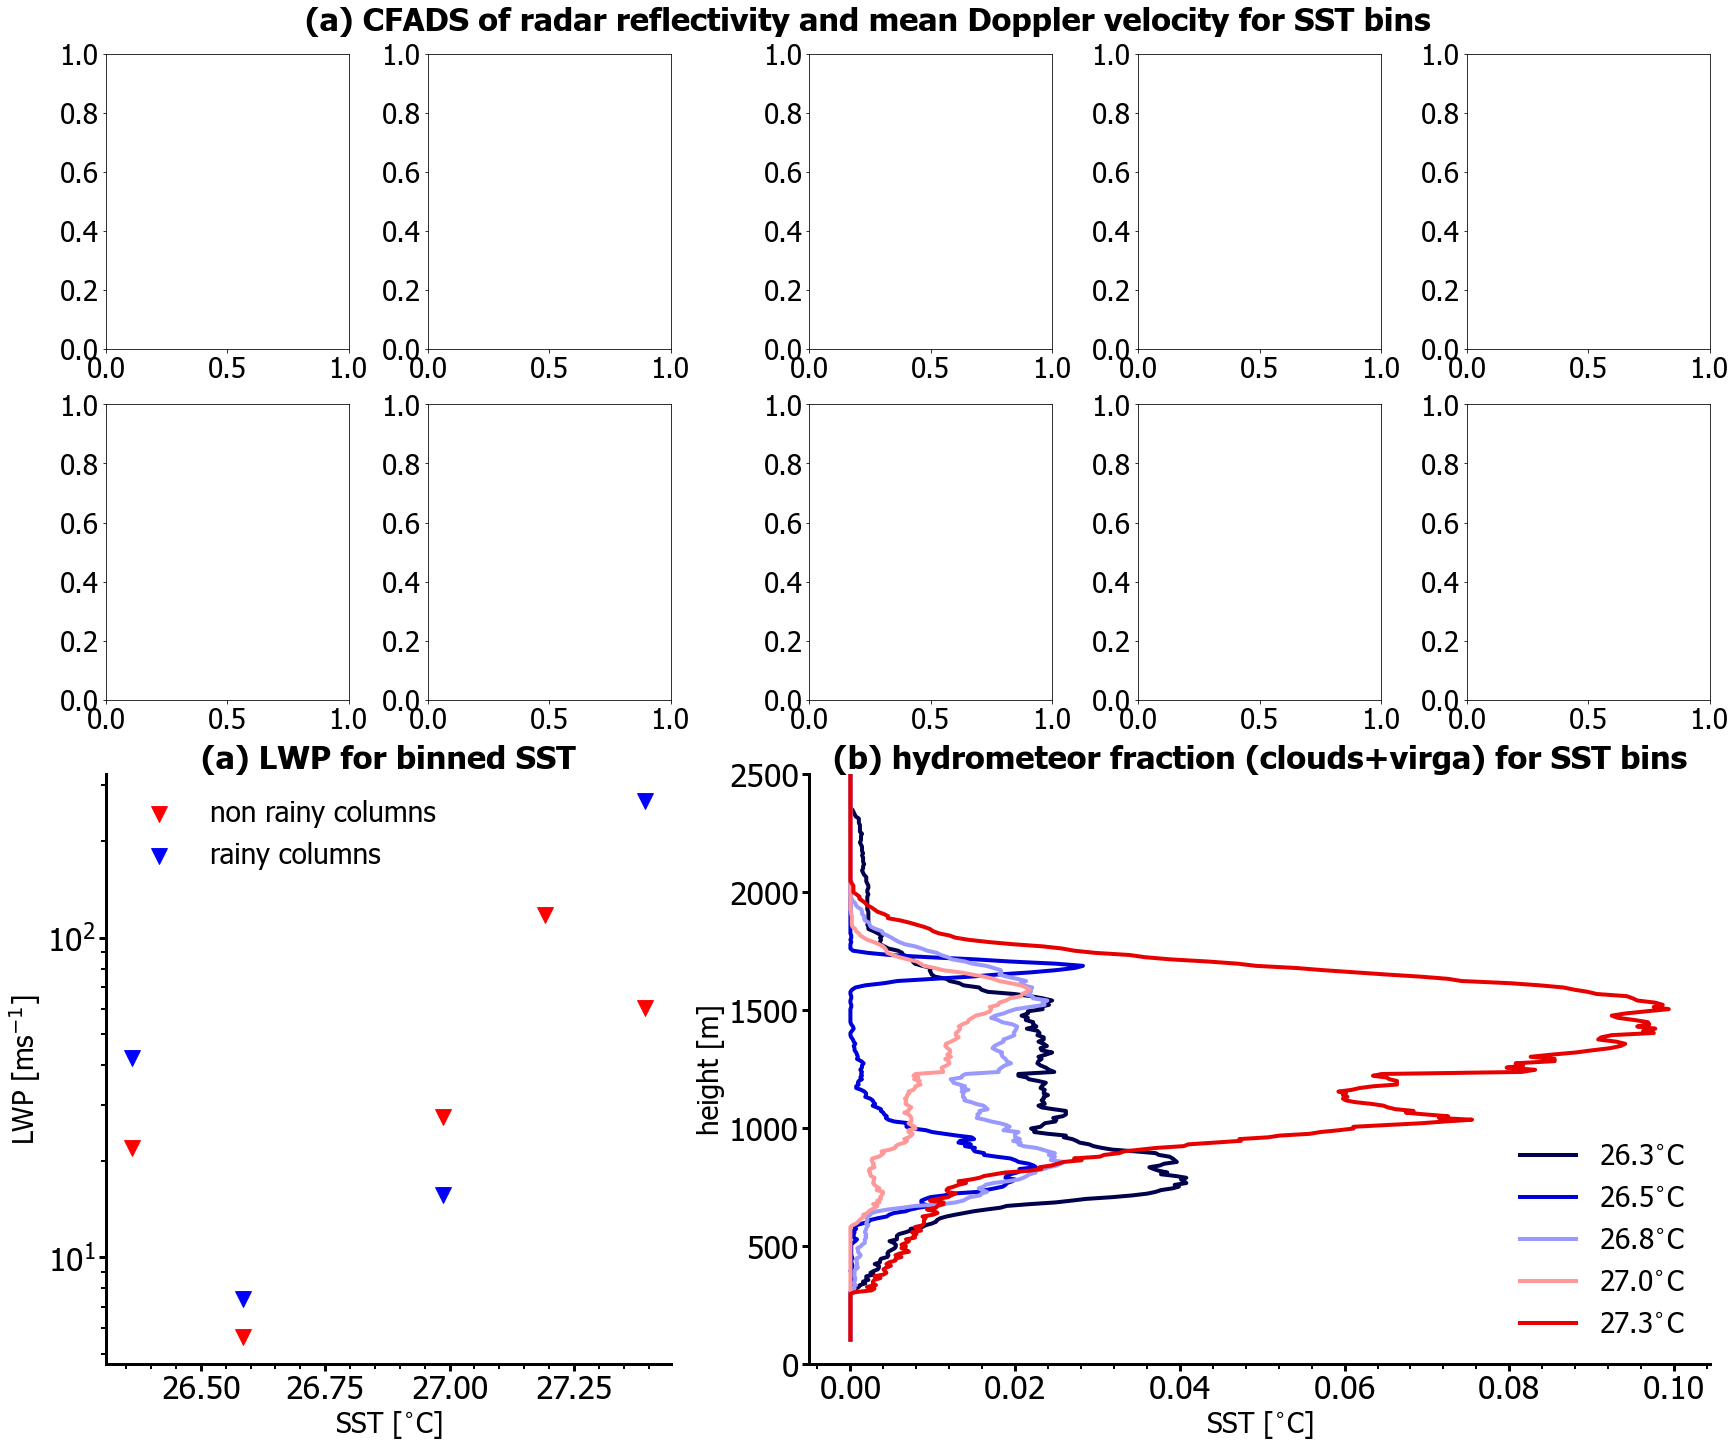

In [18]:
fig, axs = plt.subplots(3, len(SST_binned_arr)-1, figsize=(24,20), \
                        constrained_layout=True, gridspec_kw={'height_ratios': [1,1,2]})

fig.suptitle('(a) CFADS of radar reflectivity and mean Doppler velocity for SST bins', fontsize=32, fontweight='black')
# adjust the subplots, i.e. leave more space at the top to accomodate the additional titles
#fig.subplots_adjust(top=0.78) 


# extract all colors from the .jet map
import matplotlib as mpl

# defining subplot grids for the LWP and the CF plots
gs = axs[2, 0].get_gridspec()
# remove the underlying axes
for ax in axs[2, :]:
    ax.remove()
ax_LWP = fig.add_subplot(gs[2,0:2])
ax_CF = fig.add_subplot(gs[2,2:5])


ax_LWP.set_title('(a) LWP for binned SST', fontsize=32, fontweight='black')
ax_LWP.spines["top"].set_visible(False)
ax_LWP.spines["right"].set_visible(False)
ax_LWP.spines["bottom"].set_linewidth(3)
ax_LWP.spines["left"].set_linewidth(3)
ax_LWP.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax_LWP.tick_params(which='minor', length=5, width=2)
ax_LWP.tick_params(which='major', length=7, width=3)
ax_LWP.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax_LWP.tick_params(axis='both', labelsize=32)
ax_LWP.scatter(rain_binned.SST.values,no_rain_binned.liquid_water_path, marker="v", s=250, color='r', label='non rainy columns')
ax_LWP.scatter(rain_binned.SST.values,rain_binned.liquid_water_path, marker="v", s=250,  color='b', label='rainy columns')
ax_LWP.legend(frameon=False)
ax_LWP.set_yscale('log')
ax_LWP.set_ylabel('LWP [ms$^{-1}$]')
ax_LWP.set_xlabel('SST [$^{\circ}$C]')


ax_CF.set_title('(b) hydrometeor fraction (clouds+virga) for SST bins', fontsize=32, fontweight='black')

#ax_CF.text(-0.05, 1.1, 'hydrometeor fraction (clouds+virga) for SST bins',  fontweight='black', fontsize=fontSizeX, transform=ax.transAxes)
ax_CF.spines["top"].set_visible(False)
ax_CF.spines["right"].set_visible(False)
ax_CF.spines["bottom"].set_linewidth(3)
ax_CF.spines["left"].set_linewidth(3)
ax_CF.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax_CF.tick_params(which='minor', length=5, width=2)
ax_CF.tick_params(which='major', length=7, width=3)
ax_CF.xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
ax_CF.tick_params(axis='both', labelsize=32)
# plot mean profiles
for ind in range(len(SST_binned_arr)-1):
    ax_CF.plot(no_rain_binned.hyd_fraction.values[ind,:], \
            no_rain_binned.height.values,\
            color=colors_binned_sst[ind],\
            label=str(SST_binned_arr[ind])+'$^{\circ}$C',  linewidth=4, rasterized=True)
ax_CF.set_ylim(0.,  2500.)
ax_CF.set_ylabel('height [m]')
ax_CF.set_xlabel('SST [$^{\circ}$C]')
ax_CF.legend(frameon=False)   
#ax = fig.add_subplot(gs[0, 0])
#fig.tight_layout()
#fig.tight_layout(pad=0.7, h_pad=0.8, w_pad=0.2)
fig.savefig(path_out_plots+'figure_clouds_below.png', format='png')

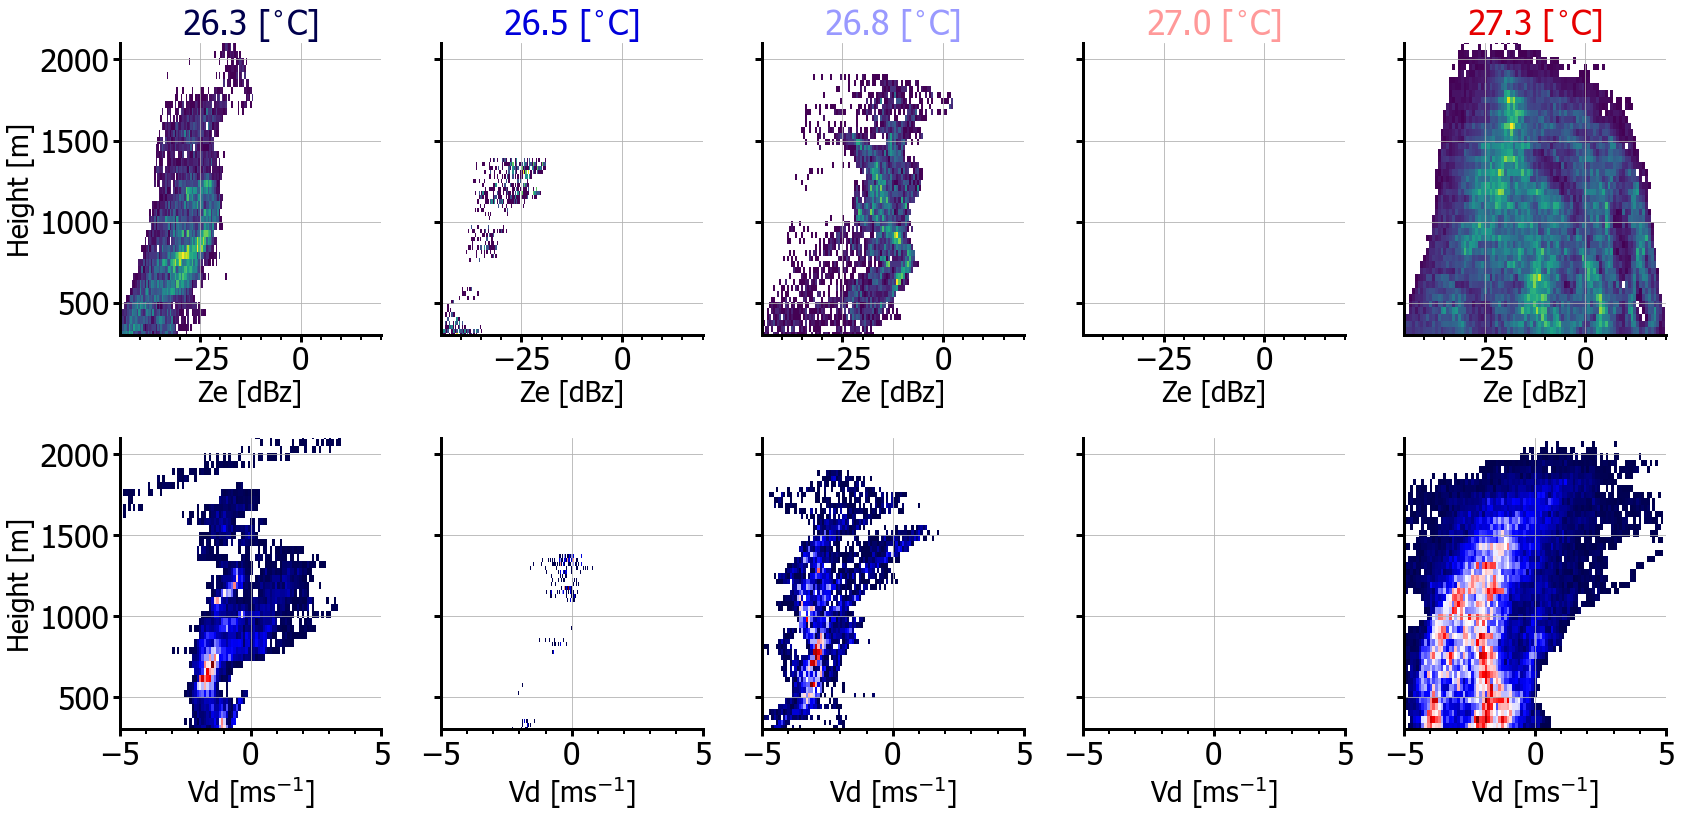

In [138]:
# plotting cfads for Ze of the binned datasets
fig, axs = plt.subplots(2,len(SST_binned_arr)-1,figsize=(24,12), sharey=True)

for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_rain_binned['radar_reflectivity'].values[ind_plot, :,:].flatten()
    hst, xcenter, ycenter = calc_2d_hist(all_rain_binned, xvar)
    cax = axs[0,ind_plot].pcolormesh(xcenter, ycenter, hst, cmap='viridis')
    axs[0,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[0,ind_plot].set_xlim(-45., 20.)
    axs[0,ind_plot].grid()
    axs[0,ind_plot].spines["top"].set_visible(False)
    axs[0,ind_plot].spines["right"].set_visible(False)
    axs[0,ind_plot].spines["bottom"].set_linewidth(3)
    axs[0,ind_plot].spines["left"].set_linewidth(3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[0,ind_plot].tick_params(which='major', length=7, width=3)
    axs[0,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[0,ind_plot].tick_params(axis='both', labelsize=32)
    axs[0,ind_plot].set_xlabel('Ze [dBz]')
    axs[0,0].set_ylabel('Height [m]')
    axs[0,ind_plot].set_title(str(SST_binned_arr[ind_plot])+' [$^{\circ}$C]', color=colors_binned_sst[ind_plot])

for ind_plot in range(len(SST_binned_arr)-1):
    xvar = all_rain_binned['mean_doppler_velocity'].values[ind_plot, :,:].flatten()
    hst, xcenter, ycenter = calc_2d_hist(all_rain_binned, xvar)
    cax = axs[1,ind_plot].pcolormesh(xcenter, ycenter, hst, cmap='seismic')
    axs[1,ind_plot].set_ylim(300.,2100.)   # limits of the y-axesn  cmap=plt.cm.get_cmap("viridis", 256)
    axs[1,ind_plot].set_xlim(-5., 5.)
    axs[1,ind_plot].grid()
    axs[1,ind_plot].spines["top"].set_visible(False)
    axs[1,ind_plot].spines["right"].set_visible(False)
    axs[1,ind_plot].spines["bottom"].set_linewidth(3)
    axs[1,ind_plot].spines["left"].set_linewidth(3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(which='minor', length=5, width=2)
    axs[1,ind_plot].tick_params(which='major', length=7, width=3)
    axs[1,ind_plot].xaxis.set_minor_locator(ticker.AutoMinorLocator(n=5))
    axs[1,ind_plot].tick_params(axis='both', labelsize=32)    
    axs[1,ind_plot].set_xlabel('Vd [ms$^{-1}$]')
    axs[1,0].set_ylabel('Height [m]')

    
fig.tight_layout()
fig.savefig(path_out_plots+'figure_cfads_rain_SST.png', format='png')